# An Analysis of Form vs Fixtures

In [1]:
import numpy as np
import pandas as pd
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Merge Player Data with Team Data

In [2]:
# Load player data
def_df = pd.read_csv('../def_finaldat.csv')
att_df = pd.read_csv('../att_finaldat.csv')
final_df = pd.concat([def_df, att_df], axis=0, ignore_index=True)

print(f"final_df shape: {final_df.shape}")
print(f"Date range: {final_df['Date'].min()} to {final_df['Date'].max()}")

final_df shape: (62884, 137)
Date range: 2017-08-11 to 2024-05-19


In [3]:
# Load team data
team_df = pd.read_csv('../team_finaldat.csv', index_col=0)

print(f"team_df shape: {team_df.shape}")
print(f"Team data columns: {team_df.columns.tolist()}")

team_df shape: (5320, 18)
Team data columns: ['Date', 'Time', 'Matchweek', 'Day', 'Venue', 'Result', 'Goals Scored', 'Goals Conceded', 'Opponent', 'xG', 'xGA', 'Possession', 'Attendance', 'Captain', 'Formation', 'Opposition Formation', 'Referee', 'Team']


In [4]:
# Merge final_df with team data
# We merge on Date and Team to add team-level context to each player's match performance
merged_df = final_df.merge(
    team_df,
    on=['Date', 'Team'],
    how='left',
    suffixes=('', '_team')
)

print(f"Merge complete!")
print(f"Original final_df: {final_df.shape}")
print(f"Merged dataset: {merged_df.shape}")
print(f"Merge success rate: {100 * merged_df['Formation'].notna().sum() / len(merged_df):.1f}%")

Merge complete!
Original final_df: (62884, 137)
Merged dataset: (62884, 153)
Merge success rate: 100.0%


In [5]:
# Clean up duplicate columns
# Drop team-suffixed columns that are identical to player data
columns_to_drop = ['Matchweek_team', 'Day_team', 'Venue_team', 'Opponent_team', 'Result_team']
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')

print(f"After cleanup: {merged_df.shape}")
print(f"\nNew columns added from team data:")
new_cols = ['Time', 'Goals Scored', 'Goals Conceded', 'xG_team', 'xGA', 
            'Possession', 'Attendance', 'Captain', 'Formation', 
            'Opposition Formation', 'Referee']
for col in new_cols:
    if col in merged_df.columns:
        print(f"  ✓ {col}")

After cleanup: (62884, 148)

New columns added from team data:
  ✓ Time
  ✓ Goals Scored
  ✓ Goals Conceded
  ✓ xG_team
  ✓ xGA
  ✓ Possession
  ✓ Attendance
  ✓ Captain
  ✓ Formation
  ✓ Opposition Formation
  ✓ Referee


## 2. Add Fixture Difficulty Rating (FDR)

We'll add FDR using:
- **2017-18**: Predictions from calibrated ordinal regression model
- **2018-19 onwards**: Observed FPL FDR data

In [6]:
# Team name harmonization (FPL naming conventions)
team_name_harmonization = {
    # Core mappings
    'Manchester City': 'Man City',
    'Manchester Utd': 'Man Utd',
    'Tottenham': 'Spurs',
    'Newcastle Utd': 'Newcastle',
    'Leicester City': 'Leicester',
    
    # Promoted team fixes
    'Leeds United': 'Leeds',
    "Nott'ham Forest": "Nott'm Forest",
    'Nottingham': "Nott'm Forest",
    'Norwich City': 'Norwich',
    'Sheffield': 'Sheffield Utd',
    'Luton Town': 'Luton',
    
    # Other teams
    'Cardiff City': 'Cardiff',
    'Huddersfield Town': 'Huddersfield',
    'Swansea City': 'Swansea',
    'Stoke City': 'Stoke',
}

merged_df['Team'] = merged_df['Team'].replace(team_name_harmonization)
merged_df['Opponent'] = merged_df['Opponent'].replace(team_name_harmonization)

print("✓ Applied team name harmonization")

✓ Applied team name harmonization


In [7]:
# Load observed FPL FDR data (2018-19 onwards)
fpl_data_path = Path('../Fantasy-Premier-League/data')
all_fixtures = []
all_teams_mapping = {}

for season_folder in sorted(fpl_data_path.iterdir()):
    if not season_folder.is_dir() or season_folder.name < '2018-19':
        continue

    fixtures_file = season_folder / 'fixtures.csv'
    if fixtures_file.exists():
        df = pd.read_csv(fixtures_file)
        df['Season'] = season_folder.name
        all_fixtures.append(df)

    teams_file = season_folder / 'teams.csv'
    if teams_file.exists():
        teams = pd.read_csv(teams_file)
        all_teams_mapping[season_folder.name] = dict(zip(teams['id'], teams['name']))
    else:
        raw_file = season_folder / 'raw.json'
        if raw_file.exists():
            with open(raw_file, 'r') as f:
                data = json.load(f)
                if 'teams' in data:
                    all_teams_mapping[season_folder.name] = {t['id']: t['name'] for t in data['teams']}

fixtures_df = pd.concat(all_fixtures, ignore_index=True)
print(f"✓ Loaded {len(fixtures_df)} FPL fixtures")

✓ Loaded 2660 FPL fixtures


In [8]:
# Create observed FDR lookup
observed_fdr = []
for _, fixture in fixtures_df.iterrows():
    season = fixture['Season']
    if season not in all_teams_mapping:
        continue

    team_h_name = all_teams_mapping[season].get(fixture['team_h'])
    team_a_name = all_teams_mapping[season].get(fixture['team_a'])

    if not team_h_name or not team_a_name:
        continue

    kickoff_time = pd.to_datetime(fixture.get('kickoff_time', None))
    if pd.isna(kickoff_time):
        continue
    kickoff_time = kickoff_time.tz_localize(None)

    if pd.notna(fixture['team_h_difficulty']):
        observed_fdr.append({
            'Date': kickoff_time,
            'Team': team_h_name,
            'Opponent': team_a_name,
            'Venue': 'Home',
            'FDR': int(fixture['team_h_difficulty'])
        })

    if pd.notna(fixture['team_a_difficulty']):
        observed_fdr.append({
            'Date': kickoff_time,
            'Team': team_a_name,
            'Opponent': team_h_name,
            'Venue': 'Away',
            'FDR': int(fixture['team_a_difficulty'])
        })

observed_fdr_df = pd.DataFrame(observed_fdr)
observed_fdr_df['Date'] = observed_fdr_df['Date'].dt.date
print(f"✓ Created observed FDR lookup: {len(observed_fdr_df)} records")

✓ Created observed FDR lookup: 5320 records


In [9]:
# Load 2017-18 predictions from FDR_Imputation_Model.ipynb
# The model training was done in that notebook - we just use the predictions here
pred_1718 = pd.read_csv('../FDR /fixtures_2017-18_predicted.csv')

# Match predictions to actual match dates from team_finaldat
team_df_1718 = pd.read_csv('../team_finaldat.csv', index_col=0)
team_df_1718['Date'] = pd.to_datetime(team_df_1718['Date'])

def get_season(date):
    if date.month >= 8:
        return f'{date.year}-{str(date.year+1)[-2:]}'
    else:
        return f'{date.year-1}-{str(date.year)[-2:]}'

team_df_1718['Season'] = team_df_1718['Date'].apply(get_season)
team_df_1718 = team_df_1718[team_df_1718['Season'] == '2017-18']
team_df_1718['Team'] = team_df_1718['Team'].replace(team_name_harmonization)
team_df_1718['Opponent'] = team_df_1718['Opponent'].replace(team_name_harmonization)

# Create 2017-18 FDR with actual dates
pred_1718_with_dates = []
for _, match in team_df_1718.iterrows():
    pred_match = pred_1718[
        (pred_1718['team_h'] == match['Team']) &
        (pred_1718['team_a'] == match['Opponent'])
    ]

    if len(pred_match) == 0:
        pred_match = pred_1718[
            (pred_1718['team_h'] == match['Opponent']) &
            (pred_1718['team_a'] == match['Team'])
        ]

        if len(pred_match) > 0:
            pred_1718_with_dates.append({
                'Date': match['Date'],
                'Team': match['Team'],
                'Opponent': match['Opponent'],
                'FDR': int(pred_match.iloc[0]['team_a_difficulty'])
            })
    else:
        pred_1718_with_dates.append({
            'Date': match['Date'],
            'Team': match['Team'],
            'Opponent': match['Opponent'],
            'FDR': int(pred_match.iloc[0]['team_h_difficulty'])
        })

pred_1718_df = pd.DataFrame(pred_1718_with_dates)
pred_1718_df['Date'] = pd.to_datetime(pred_1718_df['Date']).dt.date
print(f"✓ Created 2017-18 FDR lookup: {len(pred_1718_df)} records")

✓ Created 2017-18 FDR lookup: 760 records


In [10]:
# Combine all FDR data
all_fdr = pd.concat([pred_1718_df, observed_fdr_df], ignore_index=True)
all_fdr = all_fdr.drop_duplicates(subset=['Date', 'Team', 'Opponent'])
print(f"✓ Combined FDR lookup: {len(all_fdr)} records")

✓ Combined FDR lookup: 6080 records


In [11]:
# Merge FDR into merged_df
merged_df['Date'] = pd.to_datetime(merged_df['Date']).dt.date
merged_df = merged_df.merge(
    all_fdr[['Date', 'Team', 'Opponent', 'FDR']],
    on=['Date', 'Team', 'Opponent'],
    how='left'
)

print(f"✓ Merged FDR column")
print(f"  FDR coverage: {merged_df['FDR'].notna().sum() / len(merged_df) * 100:.1f}%")

✓ Merged FDR column
  FDR coverage: 100.0%


## 3. Validation: FDR Coverage by Season

In [12]:
# Add season column
merged_df['Season'] = merged_df['Date'].apply(get_season)

print("="*80)
print("FDR COVERAGE BY SEASON")
print("="*80)
for season in sorted(merged_df['Season'].unique()):
    season_data = merged_df[merged_df['Season'] == season]
    with_fdr = season_data['FDR'].notna().sum()
    total = len(season_data)
    pct = with_fdr / total * 100
    status = "✅" if pct >= 99 else "⚠️ " if pct > 90 else "❌"
    print(f"{season}: {with_fdr:>5,} / {total:>5,} ({pct:>5.1f}%) {status}")

print("\n" + "="*80)
print("PROMOTED TEAM VERIFICATION")
print("="*80)

for team in ['Norwich', 'Sheffield Utd', 'Luton', 'Leeds', "Nott'm Forest"]:
    team_data = merged_df[merged_df['Team'] == team]
    if len(team_data) > 0:
        with_fdr = team_data['FDR'].notna().sum()
        total = len(team_data)
        pct = with_fdr / total * 100
        status = "✅" if pct >= 99 else "⚠️ "
        print(f"{team:<20} {with_fdr:>5,} / {total:>5,} ({pct:>5.1f}%) {status}")

FDR COVERAGE BY SEASON
2017-18: 8,770 / 8,770 (100.0%) ✅
2018-19: 9,060 / 9,060 (100.0%) ✅
2019-20: 9,039 / 9,039 (100.0%) ✅
2020-21: 8,686 / 8,686 (100.0%) ✅
2021-22: 8,843 / 8,843 (100.0%) ✅
2022-23: 9,319 / 9,319 (100.0%) ✅
2023-24: 9,167 / 9,167 (100.0%) ✅

PROMOTED TEAM VERIFICATION
Norwich                820 /   820 (100.0%) ✅
Sheffield Utd        1,342 / 1,342 (100.0%) ✅
Luton                  431 /   431 (100.0%) ✅
Leeds                1,369 / 1,369 (100.0%) ✅
Nott'm Forest          971 /   971 (100.0%) ✅


## 4. Final Dataset Summary

The `merged_df` dataset now contains:
- **Player-level performance stats** (137 original columns)
- **Team-level match context** (10 columns from team_finaldat)
- **Fixture Difficulty Rating (FDR)** (1 new column)

**Total: 149 columns × 62,884 observations**

Ready for analysis!

In [13]:
# Check all unique positions in the dataset
print("All positions in dataset:")
position_counts = merged_df['Position'].value_counts()
print(position_counts)
print(f"\nTotal unique positions: {merged_df['Position'].nunique()}")

All positions in dataset:
Position
CB             11202
FW              8581
CM              6438
RB              4199
LB              4153
               ...  
LW,RW,RB           1
LW,RB,DM           1
LW,WB,CM           1
LM,RM,LB           1
RM,WB,CM,RW        1
Name: count, Length: 541, dtype: int64

Total unique positions: 541


## 5. Filter for Attacking Players

In [14]:
print("="*80)
print("FINAL DATASET SUMMARY")
print("="*80)
print(f"Shape: {merged_df.shape}")
print(f"\nKey columns:")
print(f"  - Date, Team, Opponent, Venue, Result")
print(f"  - Position, Minutes Played, total_points")
print(f"  - Formation, Opposition Formation, Possession")
print(f"  - FDR (Fixture Difficulty Rating)")
print(f"\nFDR coverage: {merged_df['FDR'].notna().sum()} / {len(merged_df)} ({merged_df['FDR'].notna().sum() / len(merged_df) * 100:.1f}%)")
print(f"\nDate range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")
print(f"Seasons: {', '.join(sorted(merged_df['Season'].unique()))}")

FINAL DATASET SUMMARY
Shape: (62884, 150)

Key columns:
  - Date, Team, Opponent, Venue, Result
  - Position, Minutes Played, total_points
  - Formation, Opposition Formation, Possession
  - FDR (Fixture Difficulty Rating)

FDR coverage: 62884 / 62884 (100.0%)

Date range: 2017-08-11 to 2024-05-19
Seasons: 2017-18, 2018-19, 2019-20, 2020-21, 2021-22, 2022-23, 2023-24


In [15]:
# Filter for attacking positions only: ST, LW, RW, AM
attacking_positions = ['FW', 'LW', 'RW', 'AM']

print("Before filtering:")
print(f"  Total observations: {len(merged_df):,}")

merged_df = merged_df[merged_df['Position'].isin(attacking_positions)]

print("\nAfter filtering for attacking positions (ST, LW, RW, AM):")
print(f"  Total observations: {len(merged_df):,}")

print("\nPosition distribution after filtering:")
print(merged_df['Position'].value_counts())

Before filtering:
  Total observations: 62,884

After filtering for attacking positions (ST, LW, RW, AM):
  Total observations: 17,143

Position distribution after filtering:
Position
FW    8581
RW    2970
LW    2903
AM    2689
Name: count, dtype: int64


In [16]:
# Check for and remove observations with 0 minutes played
print("Checking for observations with 0 minutes played...")
zero_minutes = merged_df[merged_df['Minutes Played'] == 0]
print(f"\nObservations with 0 minutes: {len(zero_minutes):,} ({len(zero_minutes)/len(merged_df)*100:.2f}%)")

if len(zero_minutes) > 0:
    print(f"\nBefore filtering: {len(merged_df):,} observations")
    merged_df = merged_df[merged_df['Minutes Played'] > 0]
    print(f"After filtering: {len(merged_df):,} observations")
    print(f"Removed: {len(zero_minutes):,} observations with 0 minutes played")
else:
    print("\n✓ No observations with 0 minutes played - no filtering needed")

Checking for observations with 0 minutes played...

Observations with 0 minutes: 0 (0.00%)

✓ No observations with 0 minutes played - no filtering needed


In [17]:
# Check for columns related to starting status
print("Checking for starting-related columns:")
starting_cols = [col for col in merged_df.columns if any(term in col.lower() for term in ['start', 'xi', 'lineup'])]
print(f"Found columns: {starting_cols}")

if starting_cols:
    print(f"\nSample values from '{starting_cols[0]}':")
    print(merged_df[starting_cols[0]].value_counts())

Checking for starting-related columns:
Found columns: ['Start']

Sample values from 'Start':
Start
Y     11056
N      5622
Y*      465
Name: count, dtype: int64


In [18]:
# Filter for starting players only (includes both 'Y' and 'Y*' for captains)
start_col = starting_cols[0] if starting_cols else 'Start'

print(f"Filtering for starting players using column: '{start_col}'")
print(f"Before filtering: {len(merged_df):,} observations")

# Store original length for comparison
original_length = len(merged_df)

# Filter for starters (both 'Y' and 'Y*' for captains)
merged_df = merged_df[merged_df[start_col].str.startswith('Y', na=False)]

print(f"After filtering: {len(merged_df):,} observations")
print(f"Removed: {original_length - len(merged_df):,} non-starting observations")

Filtering for starting players using column: 'Start'
Before filtering: 17,143 observations
After filtering: 11,521 observations
Removed: 5,622 non-starting observations


## 6. Exploratory Analysis: FDR vs Goals

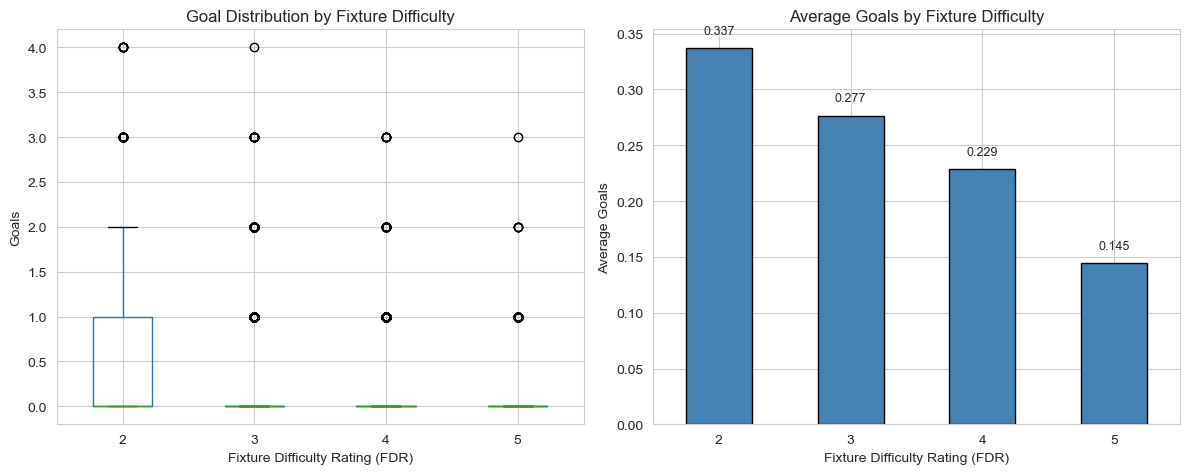


Summary Statistics: Average Goals by FDR
FDR 2: 0.3370 goals/match (n=5,653)
FDR 3: 0.2766 goals/match (n=2,881)
FDR 4: 0.2288 goals/match (n=2,413)
FDR 5: 0.1446 goals/match (n=574)


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))

# Set high-resolution saving
plt.rcParams['savefig.dpi'] = 300

# Optional but recommended: remove extra whitespace
plt.rcParams['savefig.bbox'] = 'tight'

# Subplot 1: Box plot - Goals by FDR
plt.subplot(1, 2, 1)
merged_df.boxplot(column='Goals', by='FDR', ax=plt.gca())
plt.xlabel('Fixture Difficulty Rating (FDR)')
plt.ylabel('Goals')
plt.title('Goal Distribution by Fixture Difficulty')
plt.suptitle('')  # Remove the automatic title

# Subplot 2: Bar plot - Average Goals by FDR
plt.subplot(1, 2, 2)
avg_goals_by_fdr = merged_df.groupby('FDR')['Goals'].mean()
avg_goals_by_fdr.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Fixture Difficulty Rating (FDR)')
plt.ylabel('Average Goals')
plt.title('Average Goals by Fixture Difficulty')
plt.xticks(rotation=0)

# Add value labels on bars
for i, v in enumerate(avg_goals_by_fdr):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics: Average Goals by FDR")
print("="*50)
for fdr in sorted(merged_df['FDR'].unique()):
    fdr_data = merged_df[merged_df['FDR'] == fdr]
    avg = fdr_data['Goals'].mean()
    count = len(fdr_data)
    print(f"FDR {int(fdr)}: {avg:.4f} goals/match (n={count:,})")

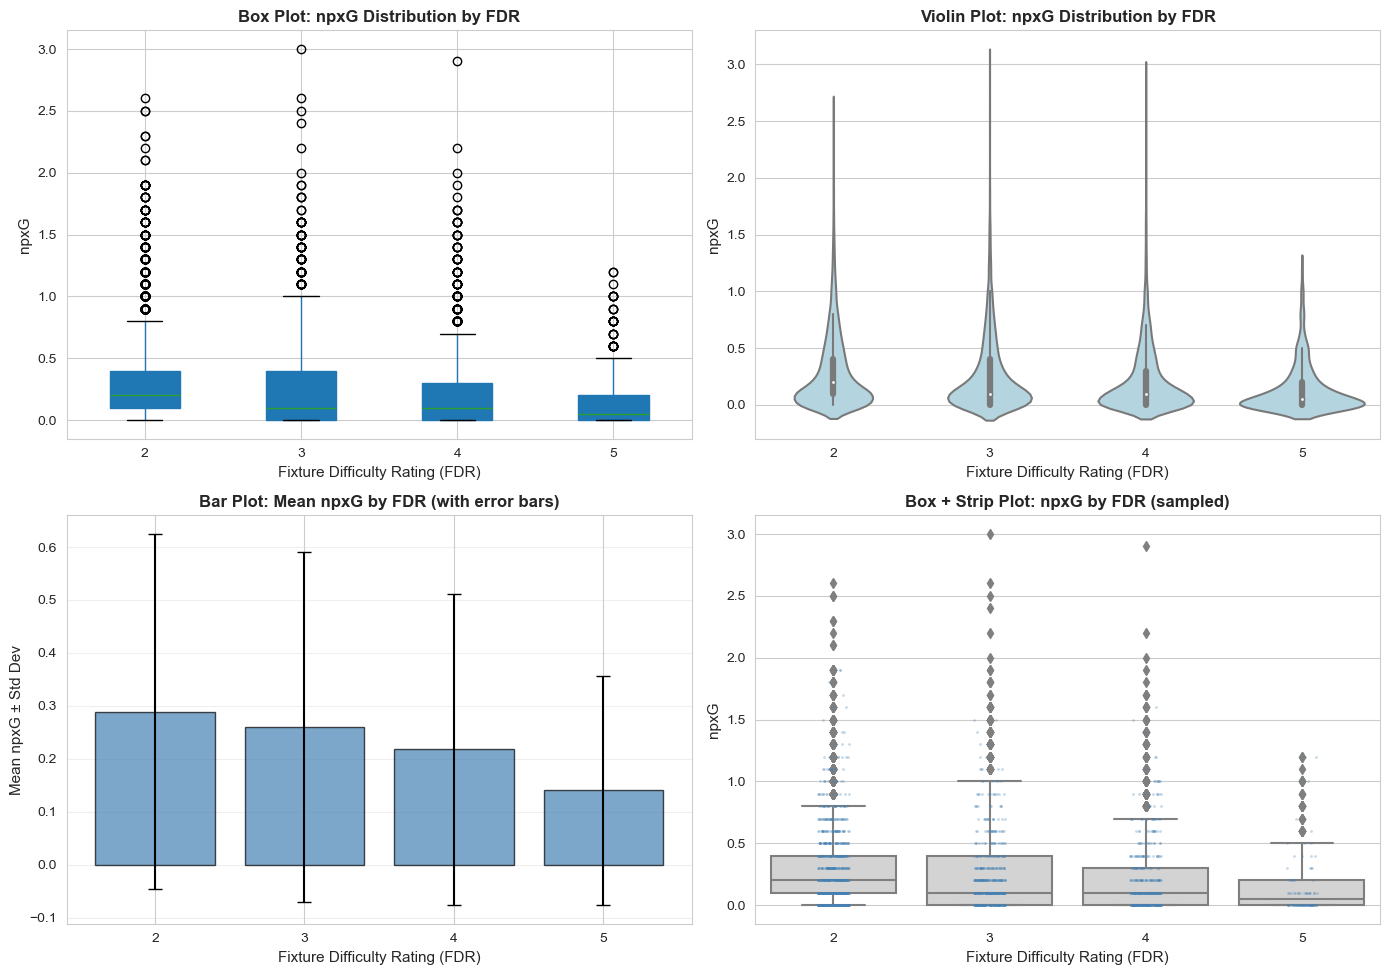


Summary Statistics: npxG by FDR
FDR   Mean     Median   Std Dev    Count     
2     0.2890   0.2000   0.3356     5,653     
3     0.2603   0.1000   0.3304     2,881     
4     0.2178   0.1000   0.2933     2,413     
5     0.1401   0.0500   0.2167     574       

Correlation between FDR and npxG: -0.1167


In [20]:
# Better visualizations for npxG (continuous) vs FDR (discrete)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Box plot
ax1 = axes[0, 0]
merged_df.boxplot(column='npxG', by='FDR', ax=ax1, patch_artist=True)
ax1.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=11)
ax1.set_ylabel('npxG', fontsize=11)
ax1.set_title('Box Plot: npxG Distribution by FDR', fontsize=12, fontweight='bold')
ax1.get_figure().suptitle('')  # Remove auto title

# Plot 2: Violin plot
ax2 = axes[0, 1]
sns.violinplot(data=merged_df, x='FDR', y='npxG', ax=ax2, color='lightblue')
ax2.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=11)
ax2.set_ylabel('npxG', fontsize=11)
ax2.set_title('Violin Plot: npxG Distribution by FDR', fontsize=12, fontweight='bold')

# Plot 3: Bar plot with error bars (mean ± std)
ax3 = axes[1, 0]
avg_npxg = merged_df.groupby('FDR')['npxG'].mean()
std_npxg = merged_df.groupby('FDR')['npxG'].std()
x_pos = range(len(avg_npxg))
ax3.bar(x_pos, avg_npxg.values, yerr=std_npxg.values, 
        color='steelblue', edgecolor='black', capsize=5, alpha=0.7)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([int(x) for x in avg_npxg.index])
ax3.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=11)
ax3.set_ylabel('Mean npxG ± Std Dev', fontsize=11)
ax3.set_title('Bar Plot: Mean npxG by FDR (with error bars)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Box plot with strip plot overlay (sampled for clarity)
ax4 = axes[1, 1]
sns.boxplot(data=merged_df, x='FDR', y='npxG', ax=ax4, color='lightgray')
# Sample data to avoid overplotting
sample_df = merged_df.sample(min(2000, len(merged_df)), random_state=42)
sns.stripplot(data=sample_df, x='FDR', y='npxG', ax=ax4, 
              size=2, alpha=0.3, color='steelblue')
ax4.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=11)
ax4.set_ylabel('npxG', fontsize=11)
ax4.set_title('Box + Strip Plot: npxG by FDR (sampled)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics: npxG by FDR")
print("="*70)
print(f"{'FDR':<5} {'Mean':<8} {'Median':<8} {'Std Dev':<10} {'Count':<10}")
print("="*70)
for fdr in sorted(merged_df['FDR'].unique()):
    fdr_data = merged_df[merged_df['FDR'] == fdr]
    mean_val = fdr_data['npxG'].mean()
    median_val = fdr_data['npxG'].median()
    std_val = fdr_data['npxG'].std()
    count = len(fdr_data)
    print(f"{int(fdr):<5} {mean_val:<8.4f} {median_val:<8.4f} {std_val:<10.4f} {count:<10,}")

# Calculate correlation
correlation = merged_df[['FDR', 'npxG']].corr().iloc[0, 1]
print(f"\nCorrelation between FDR and npxG: {correlation:.4f}")

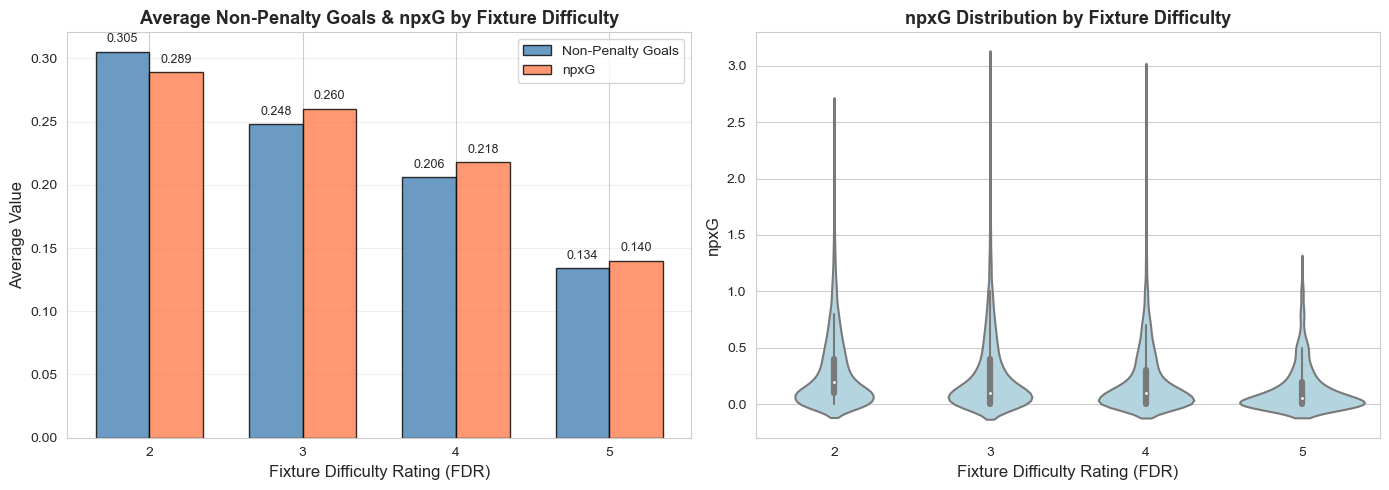

In [21]:
# Side-by-side: Grouped bar plot (Non-Penalty Goals + npxG) and Violin plot (npxG)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calculate non-penalty goals
merged_df['Non-Penalty Goals'] = merged_df['Goals'] - merged_df['Penalties Scored']

# Left plot: Grouped bar plot - Average Non-Penalty Goals and npxG by FDR
ax1 = axes[0]
avg_np_goals_by_fdr = merged_df.groupby('FDR')['Non-Penalty Goals'].mean()
avg_npxg_by_fdr = merged_df.groupby('FDR')['npxG'].mean()

x = np.arange(len(avg_np_goals_by_fdr))
width = 0.35  # Width of bars

# Create grouped bars
bars1 = ax1.bar(x - width/2, avg_np_goals_by_fdr.values, width, 
                label='Non-Penalty Goals', color='steelblue', edgecolor='black', alpha=0.8)
bars2 = ax1.bar(x + width/2, avg_npxg_by_fdr.values, width, 
                label='npxG', color='coral', edgecolor='black', alpha=0.8)

ax1.set_xticks(x)
ax1.set_xticklabels([int(i) for i in avg_np_goals_by_fdr.index])
ax1.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=12)
ax1.set_ylabel('Average Value', fontsize=12)
ax1.set_title('Average Non-Penalty Goals & npxG by Fixture Difficulty', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (v1, v2) in enumerate(zip(avg_np_goals_by_fdr.values, avg_npxg_by_fdr.values)):
    ax1.text(i - width/2, v1 + 0.005, f'{v1:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, v2 + 0.005, f'{v2:.3f}', ha='center', va='bottom', fontsize=9)

# Right plot: npxG by FDR (Violin plot) - unchanged
ax2 = axes[1]
sns.violinplot(data=merged_df, x='FDR', y='npxG', ax=ax2, color='lightblue')
ax2.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=12)
ax2.set_ylabel('npxG', fontsize=12)
ax2.set_title('npxG Distribution by Fixture Difficulty', fontsize=13, fontweight='bold')

plt.savefig('avg_npgoals_npxg_by_fdr.png', dpi = 300, bbox_inches = 'tight')

plt.tight_layout()
plt.show()

In [22]:
from scipy import stats

# Extract npxG data for FDR=2 and FDR=3
fdr2_npxg = merged_df[merged_df['FDR'] == 2]['npxG']
fdr3_npxg = merged_df[merged_df['FDR'] == 3]['npxG']

print("Statistical Comparison: FDR=2 vs FDR=3 (npxG)")
print("="*60)

# Mann-Whitney U test
u_stat, u_pval = stats.mannwhitneyu(fdr2_npxg, fdr3_npxg, alternative='two-sided')
print("\nMann-Whitney U test:")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_pval:.6f}")
print(f"  Result: {'Significantly different' if u_pval < 0.05 else 'Not significantly different'} (α=0.05)")

# Kolmogorov-Smirnov test
ks_stat, ks_pval = stats.ks_2samp(fdr2_npxg, fdr3_npxg)
print("\nKolmogorov-Smirnov test:")
print(f"  KS-statistic: {ks_stat:.4f}")
print(f"  p-value: {ks_pval:.6f}")
print(f"  Result: {'Significantly different' if ks_pval < 0.05 else 'Not significantly different'} (α=0.05)")

Statistical Comparison: FDR=2 vs FDR=3 (npxG)

Mann-Whitney U test:
  U-statistic: 8650469.5000
  p-value: 0.000002
  Result: Significantly different (α=0.05)

Kolmogorov-Smirnov test:
  KS-statistic: 0.0538
  p-value: 0.000031
  Result: Significantly different (α=0.05)


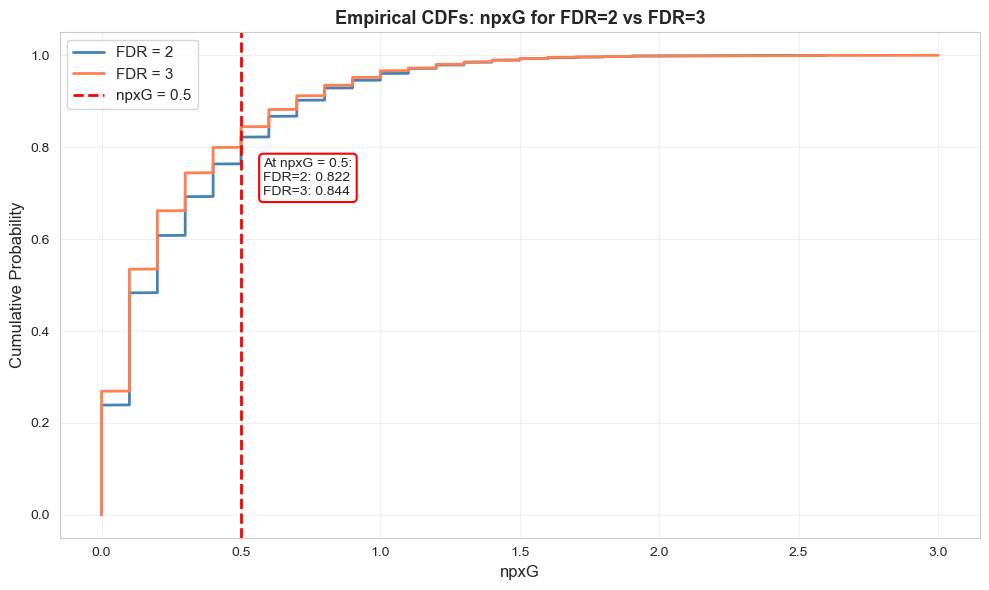

In [23]:
# Plot empirical CDFs for FDR=2 vs FDR=3
plt.figure(figsize=(10, 6))

# Sort the data
fdr2_sorted = np.sort(fdr2_npxg)
fdr3_sorted = np.sort(fdr3_npxg)

# Calculate empirical CDFs
fdr2_cdf = np.arange(1, len(fdr2_sorted) + 1) / len(fdr2_sorted)
fdr3_cdf = np.arange(1, len(fdr3_sorted) + 1) / len(fdr3_sorted)

# Plot CDFs
plt.plot(fdr2_sorted, fdr2_cdf, label='FDR = 2', linewidth=2, color='steelblue')
plt.plot(fdr3_sorted, fdr3_cdf, label='FDR = 3', linewidth=2, color='coral')

# Add vertical line at npxG = 0.5
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='npxG = 0.5')

# Calculate CDF values at npxG = 0.5
fdr2_cdf_at_05 = np.sum(fdr2_npxg <= 0.5) / len(fdr2_npxg)
fdr3_cdf_at_05 = np.sum(fdr3_npxg <= 0.5) / len(fdr3_npxg)

# Add a box with the CDF values (moved down and to the right)
avg_cdf = (fdr2_cdf_at_05 + fdr3_cdf_at_05) / 2
box_text = f'At npxG = 0.5:\nFDR=2: {fdr2_cdf_at_05:.3f}\nFDR=3: {fdr3_cdf_at_05:.3f}'
plt.text(0.58, avg_cdf - 0.1, box_text, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='red', linewidth=1.5),
         verticalalignment='center')

plt.xlabel('npxG', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('Empirical CDFs: npxG for FDR=2 vs FDR=3', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.savefig('npxg empirical cdf.png', dpi = 300, bbox_inches = 'tight')

plt.tight_layout()
plt.show()

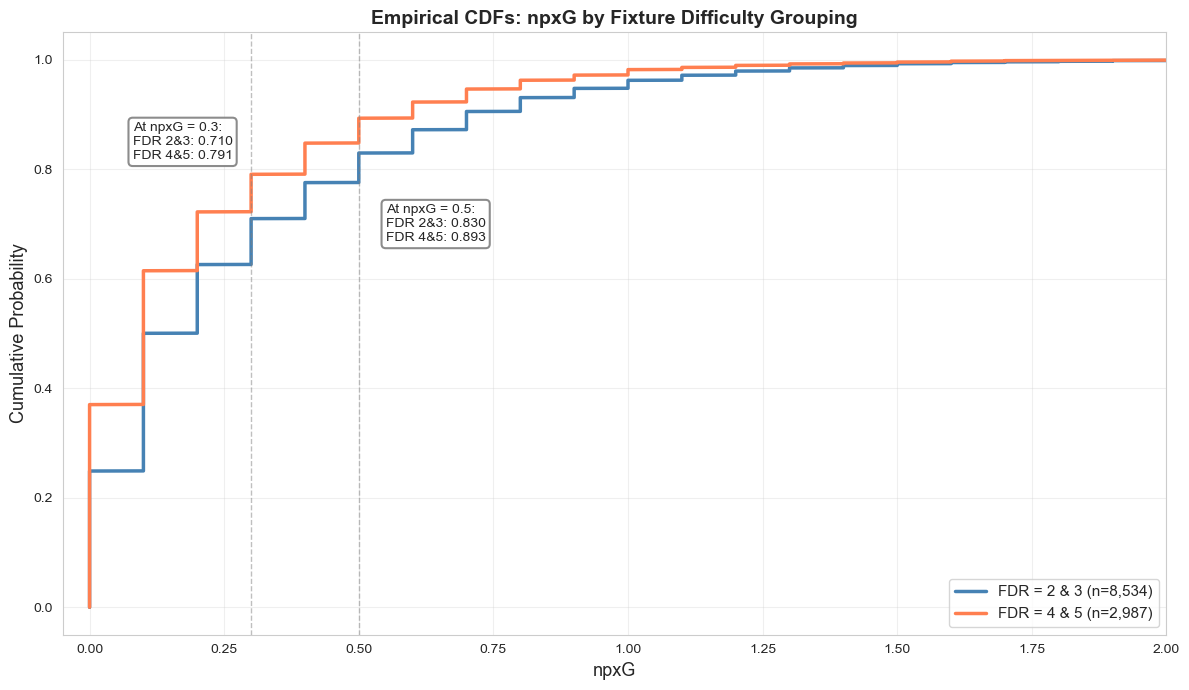

In [24]:
# Empirical CDF comparison: FDR 2&3 vs FDR 4&5
plt.figure(figsize=(12, 7))

# Group the data
fdr_2_3_npxg = merged_df[merged_df['FDR'].isin([2, 3])]['npxG']
fdr_4_5_npxg = merged_df[merged_df['FDR'].isin([4, 5])]['npxG']

# Sort the data
fdr_2_3_sorted = np.sort(fdr_2_3_npxg)
fdr_4_5_sorted = np.sort(fdr_4_5_npxg)

# Calculate empirical CDFs
fdr_2_3_cdf = np.arange(1, len(fdr_2_3_sorted) + 1) / len(fdr_2_3_sorted)
fdr_4_5_cdf = np.arange(1, len(fdr_4_5_sorted) + 1) / len(fdr_4_5_sorted)

# Plot CDFs
plt.plot(fdr_2_3_sorted, fdr_2_3_cdf, label=f'FDR = 2 & 3 (n={len(fdr_2_3_npxg):,})', 
         linewidth=2.5, color='steelblue')
plt.plot(fdr_4_5_sorted, fdr_4_5_cdf, label=f'FDR = 4 & 5 (n={len(fdr_4_5_npxg):,})', 
         linewidth=2.5, color='coral')

# Add reference lines and annotations at key npxG values
reference_points = [0.3, 0.5]
box_positions = [(0.08, 0.85), (0.55, 0.7)]  # (x, y) positions for text boxes

for npxg_val, box_pos in zip(reference_points, box_positions):
    # Add vertical reference line
    plt.axvline(x=npxg_val, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Calculate CDF values at this npxG threshold
    fdr_2_3_cdf_val = (fdr_2_3_npxg <= npxg_val).sum() / len(fdr_2_3_npxg)
    fdr_4_5_cdf_val = (fdr_4_5_npxg <= npxg_val).sum() / len(fdr_4_5_npxg)
    
    # Create annotation text
    box_text = f'At npxG = {npxg_val}:\nFDR 2&3: {fdr_2_3_cdf_val:.3f}\nFDR 4&5: {fdr_4_5_cdf_val:.3f}'
    
    # Add text box
    plt.text(box_pos[0], box_pos[1], box_text, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', 
                      linewidth=1.5, alpha=0.9),
             verticalalignment='center', horizontalalignment='left')

plt.xlabel('npxG', fontsize=13)
plt.ylabel('Cumulative Probability', fontsize=13)
plt.title('Empirical CDFs: npxG by Fixture Difficulty Grouping', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(-0.05, 2.0)

plt.savefig('npxg_empirical_cdf_grouped_by_easydifficult fixtures.png', dpi = 300, bbox_inches = 'tight')

plt.tight_layout()
plt.show()

## 7. Investigation: Why Are Non-Penalty Goals Higher Than npxG in Easy Fixtures?

From our previous analysis, we observed that:
- **FDR 2 (Easy)**: Average non-penalty goals = 0.344, Average npxG = 0.326
- **FDR 3 (Moderate)**: Average non-penalty goals = 0.320, Average npxG = 0.313

This suggests that players **outperform their expected goals** in easier fixtures. Let's investigate possible explanations:

1. **Finishing quality**: Are players more clinical against weaker defenses?
2. **Sample size effects**: Are there outlier performances skewing the average?
3. **xG model calibration**: Does the xG model underestimate goal probability in easy fixtures?
4. **Conversion rate analysis**: What is the actual conversion rate by FDR?

In [25]:
# Calculate conversion metrics by FDR
print("="*80)
print("CONVERSION ANALYSIS: NON-PENALTY GOALS vs npxG BY FDR")
print("="*80)

conversion_stats = []

for fdr in sorted(merged_df['FDR'].unique()):
    fdr_data = merged_df[merged_df['FDR'] == fdr].copy()
    
    # Calculate total goals and total npxG
    total_np_goals = fdr_data['Non-Penalty Goals'].sum()
    total_npxg = fdr_data['npxG'].sum()
    
    # Calculate averages
    avg_np_goals = fdr_data['Non-Penalty Goals'].mean()
    avg_npxg = fdr_data['npxG'].mean()
    
    # Calculate overperformance
    overperformance = avg_np_goals - avg_npxg
    overperformance_pct = (overperformance / avg_npxg * 100) if avg_npxg > 0 else 0
    
    # Conversion rate (total goals / total npxG)
    conversion_rate = (total_np_goals / total_npxg) if total_npxg > 0 else 0
    
    # Count observations
    n_obs = len(fdr_data)
    
    conversion_stats.append({
        'FDR': int(fdr),
        'N': n_obs,
        'Avg_NP_Goals': avg_np_goals,
        'Avg_npxG': avg_npxg,
        'Overperformance': overperformance,
        'Overperformance_%': overperformance_pct,
        'Conversion_Rate': conversion_rate
    })

conversion_df = pd.DataFrame(conversion_stats)

# Display the table
print(f"\n{'FDR':<5} {'N':<8} {'Avg Goals':<12} {'Avg npxG':<12} {'Diff':<10} {'Diff %':<10} {'Conv Rate':<10}")
print("-"*80)
for _, row in conversion_df.iterrows():
    print(f"{row['FDR']:<5} {row['N']:<8,} {row['Avg_NP_Goals']:<12.4f} {row['Avg_npxG']:<12.4f} "
          f"{row['Overperformance']:<10.4f} {row['Overperformance_%']:<10.2f}% {row['Conversion_Rate']:<10.4f}")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print(f"• Highest overperformance: FDR {conversion_df.loc[conversion_df['Overperformance_%'].idxmax(), 'FDR']}")
print(f"• Lowest overperformance: FDR {conversion_df.loc[conversion_df['Overperformance_%'].idxmin(), 'FDR']}")
print(f"• Conversion rate range: {conversion_df['Conversion_Rate'].min():.4f} to {conversion_df['Conversion_Rate'].max():.4f}")

CONVERSION ANALYSIS: NON-PENALTY GOALS vs npxG BY FDR

FDR   N        Avg Goals    Avg npxG     Diff       Diff %     Conv Rate 
--------------------------------------------------------------------------------
2.0   5,653.0  0.3053       0.2890       0.0163     5.65      % 1.0565    
3.0   2,881.0  0.2478       0.2603       -0.0125    -4.79     % 0.9521    
4.0   2,413.0  0.2060       0.2178       -0.0119    -5.44     % 0.9456    
5.0   574.0    0.1341       0.1401       -0.0059    -4.23     % 0.9577    

KEY FINDINGS:
• Highest overperformance: FDR 2
• Lowest overperformance: FDR 4
• Conversion rate range: 0.9456 to 1.0565


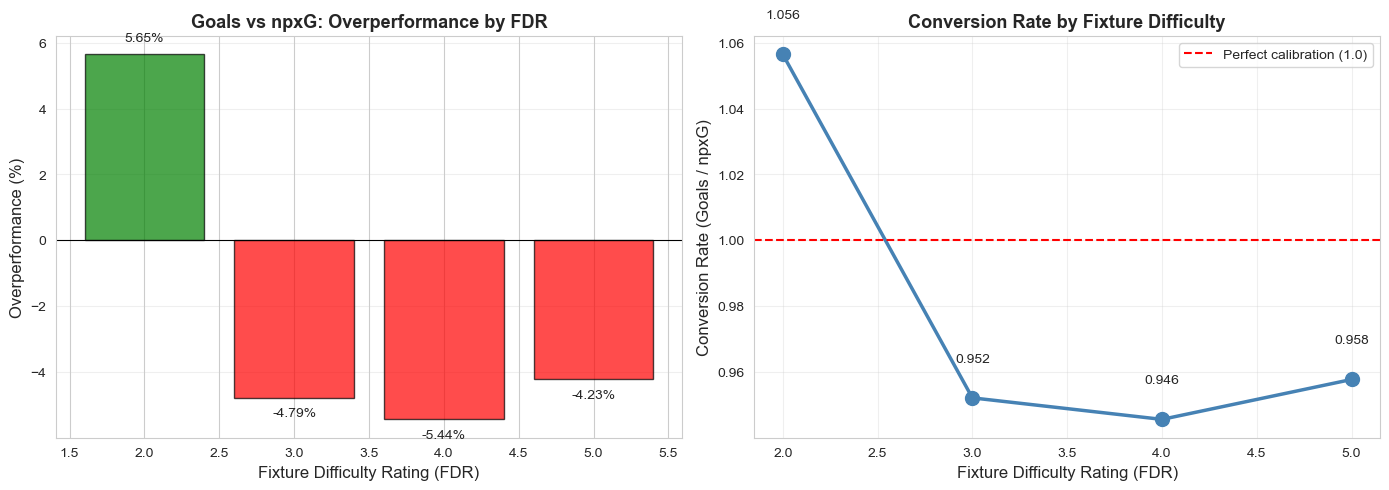


Kruskal-Wallis H-test for conversion rates across FDR groups:
  H-statistic: 28.7234
  p-value: 0.000003
  Result: Significantly different (α=0.05)


In [26]:
# Visualize conversion rates by FDR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overperformance percentage by FDR
ax1 = axes[0]
colors = ['green' if x > 0 else 'red' for x in conversion_df['Overperformance_%']]
bars = ax1.bar(conversion_df['FDR'], conversion_df['Overperformance_%'], 
               color=colors, edgecolor='black', alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax1.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=12)
ax1.set_ylabel('Overperformance (%)', fontsize=12)
ax1.set_title('Goals vs npxG: Overperformance by FDR', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (fdr, val) in enumerate(zip(conversion_df['FDR'], conversion_df['Overperformance_%'])):
    ax1.text(fdr, val + 0.3 if val > 0 else val - 0.3, f'{val:.2f}%', 
             ha='center', va='bottom' if val > 0 else 'top', fontsize=10)

# Plot 2: Conversion rate by FDR
ax2 = axes[1]
ax2.plot(conversion_df['FDR'], conversion_df['Conversion_Rate'], 
         marker='o', markersize=10, linewidth=2.5, color='steelblue')
ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, label='Perfect calibration (1.0)')
ax2.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=12)
ax2.set_ylabel('Conversion Rate (Goals / npxG)', fontsize=12)
ax2.set_title('Conversion Rate by Fixture Difficulty', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Add value labels
for fdr, rate in zip(conversion_df['FDR'], conversion_df['Conversion_Rate']):
    ax2.text(fdr, rate + 0.01, f'{rate:.3f}', ha='center', va='bottom', fontsize=10)

plt.savefig('conversion_rate_analysis_by_fdr.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Statistical test: Is the conversion rate significantly different across FDR groups?
from scipy.stats import kruskal

# Group data by FDR and calculate individual conversion rates (goals/npxG for each match)
conversion_by_match = []
for fdr in sorted(merged_df['FDR'].unique()):
    fdr_data = merged_df[merged_df['FDR'] == fdr].copy()
    # Only include matches where npxG > 0 to avoid division by zero
    fdr_data = fdr_data[fdr_data['npxG'] > 0]
    fdr_data['Individual_Conversion'] = fdr_data['Non-Penalty Goals'] / fdr_data['npxG']
    conversion_by_match.append(fdr_data['Individual_Conversion'])

# Kruskal-Wallis H-test (non-parametric alternative to ANOVA)
h_stat, p_val = kruskal(*conversion_by_match)

print(f"\nKruskal-Wallis H-test for conversion rates across FDR groups:")
print(f"  H-statistic: {h_stat:.4f}")
print(f"  p-value: {p_val:.6f}")
print(f"  Result: {'Significantly different' if p_val < 0.05 else 'Not significantly different'} (α=0.05)")

## 8. Scatter Plot: npxG vs Actual Goals (Color-Coded by FDR)

This visualization shows the relationship between expected goals (npxG) and actual non-penalty goals scored in each match, with colors representing fixture difficulty.

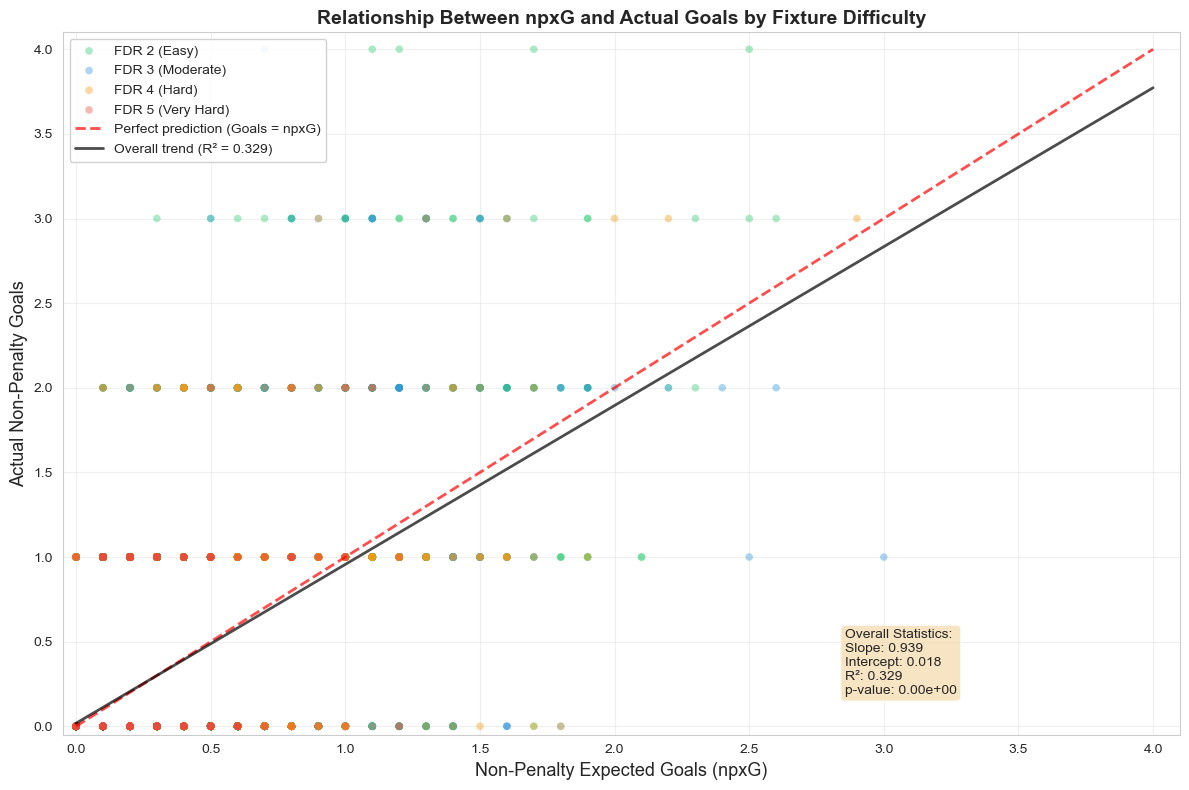

CORRELATION ANALYSIS: npxG vs Goals by FDR
FDR   N        Correlation     R²         p-value     
--------------------------------------------------------------------------------
2     5,653    0.5776          0.3336     0.00e+00    
3     2,881    0.5610          0.3147     1.41e-238   
4     2,413    0.5632          0.3171     5.53e-202   
5     574      0.5200          0.2704     4.38e-41    


In [27]:
# Create scatter plot: npxG vs Non-Penalty Goals, color-coded by FDR
plt.figure(figsize=(12, 8))

# Define colormap for FDR (2=easy -> 5=difficult)
fdr_colors = {2: '#2ecc71', 3: '#3498db', 4: '#f39c12', 5: '#e74c3c'}
fdr_labels = {2: 'FDR 2 (Easy)', 3: 'FDR 3 (Moderate)', 4: 'FDR 4 (Hard)', 5: 'FDR 5 (Very Hard)'}

# Plot each FDR group
for fdr in sorted(merged_df['FDR'].unique()):
    fdr_data = merged_df[merged_df['FDR'] == fdr]
    plt.scatter(fdr_data['npxG'], fdr_data['Non-Penalty Goals'], 
                c=fdr_colors.get(fdr, 'gray'), 
                label=fdr_labels.get(fdr, f'FDR {int(fdr)}'),
                alpha=0.4, s=30, edgecolors='none')

# Add perfect prediction line (y = x)
max_val = max(merged_df['npxG'].max(), merged_df['Non-Penalty Goals'].max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction (Goals = npxG)', alpha=0.7)

# Add regression line for all data
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(merged_df['npxG'], merged_df['Non-Penalty Goals'])
x_line = np.linspace(0, max_val, 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'k-', linewidth=2, label=f'Overall trend (R² = {r_value**2:.3f})', alpha=0.7)

# Labels and formatting
plt.xlabel('Non-Penalty Expected Goals (npxG)', fontsize=13)
plt.ylabel('Actual Non-Penalty Goals', fontsize=13)
plt.title('Relationship Between npxG and Actual Goals by Fixture Difficulty', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.xlim(-0.05, max_val + 0.1)
plt.ylim(-0.05, max_val + 0.1)

# Add annotation with regression statistics
stats_text = f'Overall Statistics:\n'
stats_text += f'Slope: {slope:.3f}\n'
stats_text += f'Intercept: {intercept:.3f}\n'
stats_text += f'R²: {r_value**2:.3f}\n'
stats_text += f'p-value: {p_value:.2e}'

plt.text(0.70, 0.15, stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.savefig('npxg_vs_goals_scatter_by_fdr.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Print correlation by FDR group
print("="*80)
print("CORRELATION ANALYSIS: npxG vs Goals by FDR")
print("="*80)
print(f"{'FDR':<5} {'N':<8} {'Correlation':<15} {'R²':<10} {'p-value':<12}")
print("-"*80)

for fdr in sorted(merged_df['FDR'].unique()):
    fdr_data = merged_df[merged_df['FDR'] == fdr]
    slope, intercept, r_value, p_value, std_err = linregress(fdr_data['npxG'], fdr_data['Non-Penalty Goals'])
    print(f"{int(fdr):<5} {len(fdr_data):<8,} {r_value:<15.4f} {r_value**2:<10.4f} {p_value:<12.2e}")

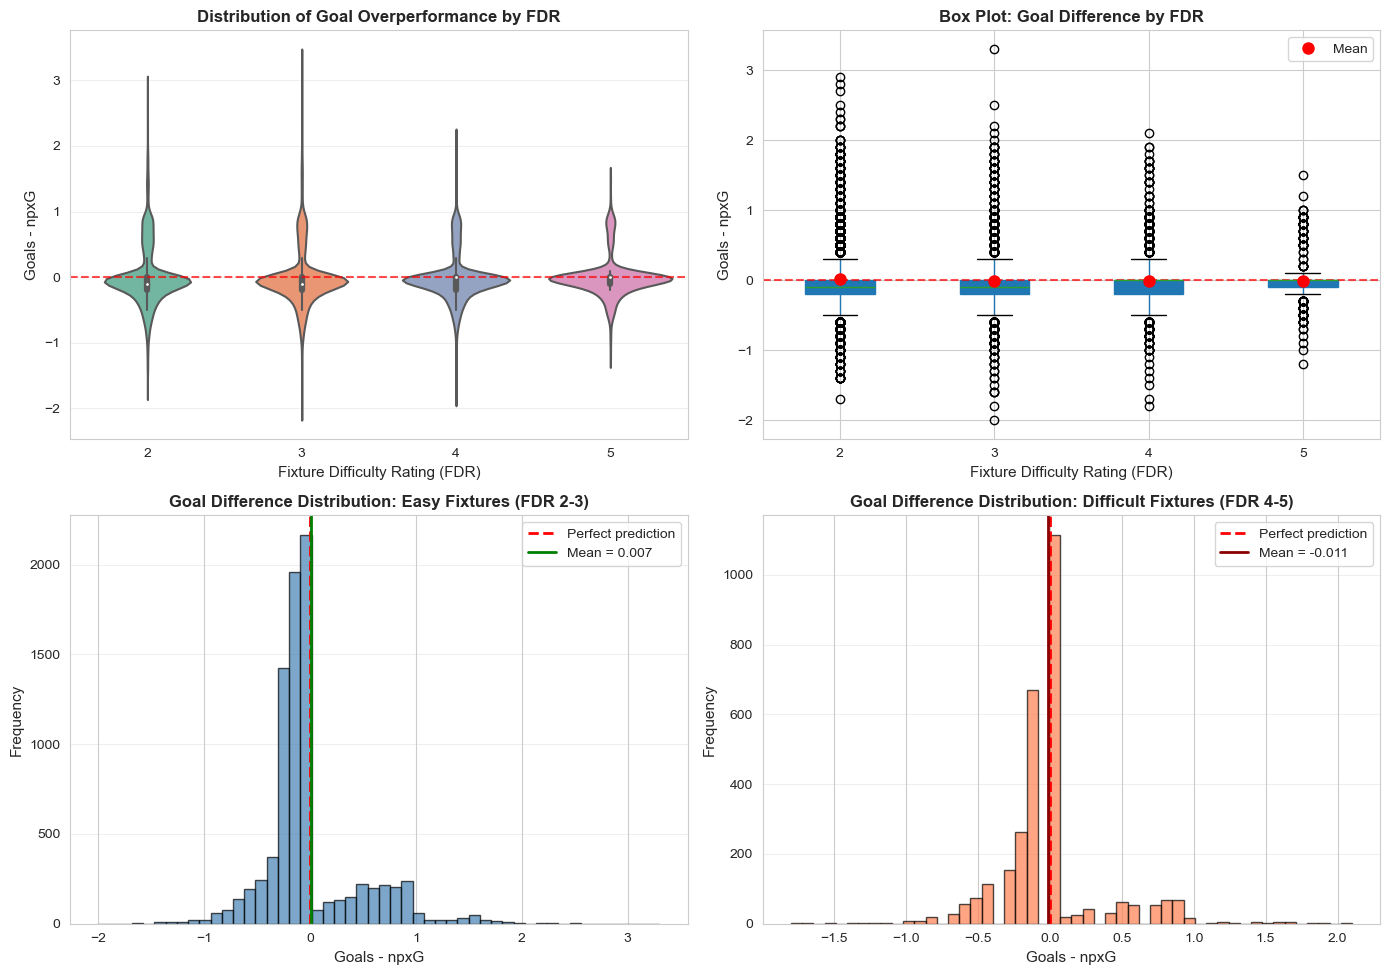

GOAL DIFFERENCE STATISTICS: (Goals - npxG) BY FDR
FDR   Mean       Median     Std Dev    % Positive  
--------------------------------------------------------------------------------
2     0.0163     -0.1000    0.4627     23.0        %
3     -0.0125    -0.1000    0.4385     18.3        %
4     -0.0119    0.0000     0.3776     16.6        %
5     -0.0059    0.0000     0.3097     12.0        %

KEY INSIGHTS:
• Easy fixtures (FDR 2-3) mean difference: 0.0066
• Difficult fixtures (FDR 4-5) mean difference: -0.0107
• Difference: 0.0173 goals per match

Mann-Whitney U test (Easy vs Difficult):
  p-value: 0.002669
  Result: Significantly different (α=0.05)


In [28]:
# Additional analysis: Distribution of (Goals - npxG) by FDR
# This shows whether players consistently overperform or if it's driven by outliers

merged_df['Goal_Difference'] = merged_df['Non-Penalty Goals'] - merged_df['npxG']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Violin plot of goal difference by FDR
ax1 = axes[0, 0]
sns.violinplot(data=merged_df, x='FDR', y='Goal_Difference', ax=ax1, palette='Set2')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=11)
ax1.set_ylabel('Goals - npxG', fontsize=11)
ax1.set_title('Distribution of Goal Overperformance by FDR', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Box plot with means
ax2 = axes[0, 1]
bp = merged_df.boxplot(column='Goal_Difference', by='FDR', ax=ax2, patch_artist=True)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Fixture Difficulty Rating (FDR)', fontsize=11)
ax2.set_ylabel('Goals - npxG', fontsize=11)
ax2.set_title('Box Plot: Goal Difference by FDR', fontsize=12, fontweight='bold')
ax2.get_figure().suptitle('')

# Add mean markers
means = merged_df.groupby('FDR')['Goal_Difference'].mean()
positions = range(1, len(means) + 1)
ax2.plot(positions, means.values, 'ro', markersize=8, label='Mean', zorder=3)
ax2.legend()

# Plot 3: Histogram of goal difference for easy fixtures (FDR 2&3)
ax3 = axes[1, 0]
easy_fixtures = merged_df[merged_df['FDR'].isin([2, 3])]
ax3.hist(easy_fixtures['Goal_Difference'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
ax3.axvline(x=easy_fixtures['Goal_Difference'].mean(), color='green', linestyle='-', linewidth=2, 
            label=f'Mean = {easy_fixtures["Goal_Difference"].mean():.3f}')
ax3.set_xlabel('Goals - npxG', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Goal Difference Distribution: Easy Fixtures (FDR 2-3)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Histogram for difficult fixtures (FDR 4&5)
ax4 = axes[1, 1]
difficult_fixtures = merged_df[merged_df['FDR'].isin([4, 5])]
ax4.hist(difficult_fixtures['Goal_Difference'], bins=50, color='coral', edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
ax4.axvline(x=difficult_fixtures['Goal_Difference'].mean(), color='darkred', linestyle='-', linewidth=2,
            label=f'Mean = {difficult_fixtures["Goal_Difference"].mean():.3f}')
ax4.set_xlabel('Goals - npxG', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Goal Difference Distribution: Difficult Fixtures (FDR 4-5)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.savefig('goal_difference_distribution_by_fdr.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Statistical summary
print("="*80)
print("GOAL DIFFERENCE STATISTICS: (Goals - npxG) BY FDR")
print("="*80)
print(f"{'FDR':<5} {'Mean':<10} {'Median':<10} {'Std Dev':<10} {'% Positive':<12}")
print("-"*80)

for fdr in sorted(merged_df['FDR'].unique()):
    fdr_data = merged_df[merged_df['FDR'] == fdr]['Goal_Difference']
    mean_diff = fdr_data.mean()
    median_diff = fdr_data.median()
    std_diff = fdr_data.std()
    pct_positive = (fdr_data > 0).sum() / len(fdr_data) * 100
    
    print(f"{int(fdr):<5} {mean_diff:<10.4f} {median_diff:<10.4f} {std_diff:<10.4f} {pct_positive:<12.1f}%")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)

# Compare easy vs difficult fixtures
easy_mean = merged_df[merged_df['FDR'].isin([2, 3])]['Goal_Difference'].mean()
difficult_mean = merged_df[merged_df['FDR'].isin([4, 5])]['Goal_Difference'].mean()
print(f"• Easy fixtures (FDR 2-3) mean difference: {easy_mean:.4f}")
print(f"• Difficult fixtures (FDR 4-5) mean difference: {difficult_mean:.4f}")
print(f"• Difference: {easy_mean - difficult_mean:.4f} goals per match")

# Test if difference is significant
from scipy.stats import mannwhitneyu
easy_diff = merged_df[merged_df['FDR'].isin([2, 3])]['Goal_Difference']
difficult_diff = merged_df[merged_df['FDR'].isin([4, 5])]['Goal_Difference']
u_stat, p_val = mannwhitneyu(easy_diff, difficult_diff, alternative='two-sided')
print(f"\nMann-Whitney U test (Easy vs Difficult):")
print(f"  p-value: {p_val:.6f}")
print(f"  Result: {'Significantly different' if p_val < 0.05 else 'Not significantly different'} (α=0.05)")